# Contemporaneous and lagged causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.

This tutorial explains the function ``PCMCI.run_pcmciplus``. In contrast to standard ``PCMCI.run_pcmci``, PCMCIplus allows to identify the full, lagged and contemporaneous, causal graph (up to the Markov equivalence class for contemporaneous links) under the standard assumptions of Causal Sufficiency, Faithfulness and the Markov condition. 

PCMCIplus is described here:
J. Runge (2020), Discovering contemporaneous and lagged causal relations in autocorrelated nonlinear time series datasets
http://www.auai.org/uai2020/proceedings/579_main_paper.pdf

See the following paper for theoretical background:
Runge, Jakob. 2018. “Causal Network Reconstruction from Time Series: From Theoretical Assumptions to Practical Estimation.” Chaos: An Interdisciplinary Journal of Nonlinear Science 28 (7): 075310.

Last, the following Nature Communications Perspective paper provides an overview of causal inference methods in general, identifies promising applications, and discusses methodological challenges (exemplified in Earth system sciences): 
https://www.nature.com/articles/s41467-019-10105-3

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import xarray as xr
import pandas as pd

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr

/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/../versions.py'
  warnings.warn(str(e))
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: [Errno 2] No such file or directory: '/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/../../versions.py'
  warnings.warn(str(e))
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'torch'
  warnings.warn(str(e))


## 1. Structural causal processes with contemporaneous and lagged dependencies



## Analysis Parameters


<!-- CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Daily.nc

CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Monthly.nc -->

<!-- Tumbarumba/2022_v1/L6/default/Tumbarumba_L6_20020107_20191231_Daily.nc

'AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Daily.nc'

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Monthly.nc

'Tumbarumba/2022_v1/L6/default/Tumbarumba_L6_20020107_20191231_Monthly.nc'

/Gingin/2022_v1/L6/default/Gingin_L6_20111013_20201231_Monthly.nc

Gingin/2022_v1/L6/default/Gingin_L6_20111013_20201231_Daily.nc

CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Monthly.nc

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Monthly.nc

Whroo/2022_v1/L6/default/Whroo_L6_20111201_20220218_Monthly.nc

Whroo/2022_v1/L6/default/Whroo_L6_20111201_20220218_Daily.nc

DryRiver/2022_v1/L6/default/DryRiver_L6_20091025_20220218_Monthly.nc

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Daily.nc

GreatWesternWoodlands/2022_v1/L6/default/GreatWesternWoodlands_L6_20130101_20220101_Daily.nc

GreatWesternWoodlands/2022_v1/L6/default/GreatWesternWoodlands_L6_20130101_20220101_Monthly.nc -->

In [2]:
site = 'Whroo/2022_v1/L6/default/Whroo_L6_20111201_20220218_Monthly.nc'
var = ['GPP_SOLO', 'Ta', 'VPD','Precip', 'Fsd']
var_names = ['GPP','Ta', 'VPD', 'precip', 'solar']
max_lag = 6
# time='2019-01-01', '2019-12-30'

## Load data

In [3]:
def VPD(rh, ta):
    sat_vp = (6.11 * np.exp((2500000/461) * (1/273 - 1/(273 + ta))))
    vpd = (((100 - rh)/100) * sat_vp)
    return vpd

ds = xr.open_dataset('https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/'+site)
# ds = ds.sel(time=slice(time[0], time[1]))
ds['GPP_SOLO'] = xr.where(ds.GPP_SOLO < 0, 0, ds.GPP_SOLO)  #Set negative GPP, ER, and ET measurements as zero
ds['ER_SOLO'] = xr.where(ds.ER_SOLO < 0, 0, ds.ER_SOLO)  #Set negative GPP, ER, and ET measurements as zero
ds['ET'] = xr.where(ds.ET < 0, 0, ds.ET)  #Set negative GPP, ER, and ET measurements as zero
ds['VPD'] = VPD(ds.RH, ds.Ta)

ds_clim_mean = ds.groupby('time.month').mean()
ds = (ds.groupby('time.month') - ds_clim_mean)

df = ds.to_dataframe().reset_index(
        level=[1, 2]).drop(['latitude', 'longitude'], axis=1)

# calculate VPD on ec data
#df['VPD'] = VPD(df.RH, df.Ta)
df = df[var].dropna()

data = df.values
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
dataframe = pp.DataFrame(data, 
                         datatime = {0:np.arange(len(data))}, 
                         var_names=var_names)

## 2. PCMCI+: Causal discovery for contemporaneous and lagged dependencies

The goal of PCMCIplus is to reconstruct the graph $\mathcal{G}$. We will see that, even with infinite sample size and all assumptions being fulfilled, this is not always possible and graphs can only be reconstructed up to a Markov equivalence class. 


### PCMCIplus Algorithm

Compared to the standard PC algorithm adapted to time series, PCMCIplus is based on two central ideas: First, the skeleton phase is conducted separately for lagged and contemporaneous conditioning sets and the lagged phase uses much less tests leading to more power. Secondly, PCMCIplus modifies the conditioning sets for the individual conditional independence tests to make them well-calibrated under autocorrelation and increase detection power by utilizing the momentary conditional independence (MCI) approach. In summary, PCMCIplus estimates time-lagged and contemporaneous causal links by a four-phase algorithm (see detailed pseudo-code in the paper):

1.  **Skeleton discovery phase with lagged conditions** (same as for PCMCI): For each variable $X^j_t$, estimate a *superset* of lagged ($\tau>0$) parents $\widehat{\mathcal{B}}_t^-( X^j_t)$ with the iterative PC1 algorithm, implemented as ``run_pc_stable``.

2.   **Skeleton discovery phase with contemporaneous conditions and *momentary conditional independence* (MCI) tests**: Iterate through subsets $\mathcal{S}\subset \mathbf{X}_t$ of contemporaneous adjacencies and remove adjacencies for all (lagged and contemporaneous) ordered pairs $(X^i_{t-\tau}, X^j_t)$ with $X^j_{t} \in \mathbf{X}_t$ and $X^i_{t-\tau} \in \mathbf{X}_t \cup \widehat{\mathcal{B}}_t^-(X^j_t)$ if the MCI conditional independence holds ($\widehat{\mathcal{B}}_{t-\tau}^-(X^i_{t-{\tau}})$ are the parents of $X^i_{t-\tau}$):

\begin{align}
    X^i_{t-\tau} &~\perp~ X^j_{t} ~|~ \mathcal{S}, \widehat{\mathcal{B}}_t^-(X^j_t), \widehat{\mathcal{B}}_{t-\tau}^-(X^i_{t-{\tau}})
\end{align}

3.   **Collider orientation phase**: Orient contemporaneous links based on unshielded triples. Optionally apply conservative or majority rule (also based on MCI tests).

4.   **Rule orientation phase**: Orient remaining contemporaneous links based on rules R1-R3 in paper.

Phases 2-4 are implemented in ``run_pcalg`` with the parameter ``mode='contemp_conds'``.
The MCI test conditions on the lagged supersets of parents for *both* $X^i_{t-\tau}$ and $X^j_t$, which is the same idea as in PCMCI. The reasoning behind this is discussed in detail in the paper where also the consistency and order independence of PCMCIplus are proven.

In contrast to PCMCI, the relevant output of PCMCIplus is the array ``graph``. Its entries are interpreted as follows (under the standard assumptions of Causal Sufficiency, Faithfulness and the Markov condition):

 * ``graph[i,j,tau]='-->'`` for ``tau > 0`` denotes a directed, lagged causal link $X^i_{t-\tau} \to X^j_t$

 * ``graph[i,j,0]='-->'`` and ``graph[j,i,0]='<--'`` denotes a directed, contemporaneous causal link $X^i_{t} \to X^j_t$

 * ``graph[i,j,0]='o-o'`` and ``graph[j,i,0]='o-o'`` denotes an unoriented, contemporaneous adjacency $X^i_{t} - X^j_t$ indicating that the collider and orientation rules could not be applied (Markov equivalence)
 
 * ``graph[i,j,0]='x-x'`` and ``graph[j,i,0]='x-x'`` denotes a conflicting, contemporaneous adjacency between $X^i_{t}$ and $X^j_t$ indicating that the directionality is undecided due to conflicting orientation rules
 
An example of a conflict is when an adjacency  $X^i_{t} - X^j_t$ is part of two triples and the collider rules applied to one triple suggests  $X^i_{t} \to X^j_t$ while for the other triple it suggests  $X^i_{t} \leftarrow X^j_t$. This can happen due to finite sample effects or violations of the assumptions.

Importantly, ``p_matrix`` and ``val_matrix`` for PCMCIplus quantify the uncertainty and strength, respectively, only for the *adjacencies* in phase 2, but not for the *directionality* of contemporaneous links determined in phases 3 and 4. Note that lagged links are always oriented due to time order.

### Parameters

PCMCIplus can be flexibly combined with any kind of conditional independence test statistic adapted to the kind of data (continuous or discrete) and its assumed dependency types. These are available in ``tigramite.independence_tests``.

The main free parameters of PCMCIplus (in addition to free parameters of the conditional independence tests) are the maximum time delay $\tau_{\max}$ (``tau_max``) and the significance threshold $\alpha_{\rm PC}$ ( ``pc_alpha``). If a list or None is passed for ``pc_alpha``, the significance level is optimized for every graph across the given ``pc_alpha`` values using the score computed in ``cond_ind_test.get_model_selection_criterion()``. The maximum time delay depends on the application and should be chosen according to the maximum causal time lag expected in the complex system. We recommend a rather large choice that includes peaks in the ``run_bivci`` function. Another important parameter is ``contemp_collider_rule``. Only if set to ``majority`` (default) or ``conservative`` and together with ``conflict_resolution=True`` (default), PCMCIplus is fully *order independent* as discussed above, meaning that the order of the N variables in the dataframe does not matter. Last, the default option ``reset_lagged_links=False`` restricts the detection of lagged causal links in phase 2 to the significant adjacencies found in phase 1, given by $\widehat{\mathcal{B}}_t^-( X^j_t)$. For ``reset_lagged_links=True``, *all* lagged links are considered again, which improves detection power for lagged links, but also leads to larger runtimes. Further optional parameters are discussed in the paper or documentation.


## 3. Application example

To conduct a PCMCIplus analysis on the above example process, first we plot the time series. This can be done with the function ``tp.plot_timeseries``:

(<Figure size 1080x360 with 5 Axes>,
 array([<AxesSubplot:ylabel='GPP'>, <AxesSubplot:ylabel='Ta'>,
        <AxesSubplot:ylabel='VPD'>, <AxesSubplot:ylabel='precip'>,
        <AxesSubplot:xlabel='time', ylabel='solar'>], dtype=object))

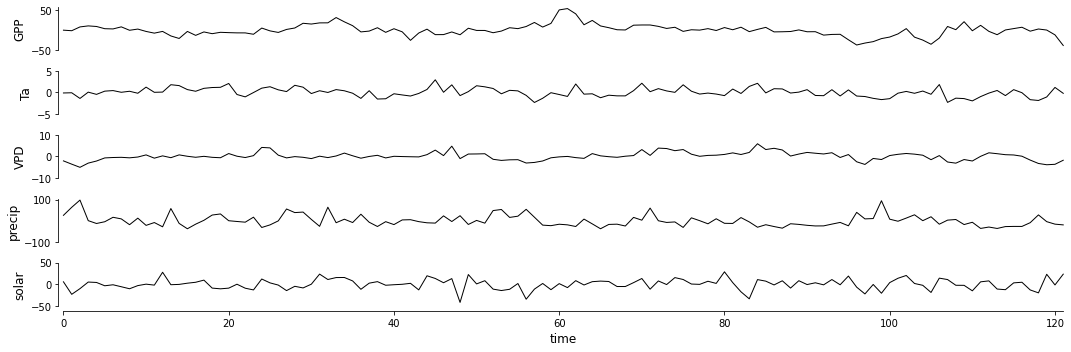

In [4]:
tp.plot_timeseries(dataframe, figsize=(15, 5))

Despite the high autocorrelation, it's stationary and doesn't contain missing values. Check the other tutorials for discussions of non-stationarity and missing values. 

Next, we choose a conditional independence test, here we assume linear dependencies with ``ParCorr`` implementing linear partial correlation. With ``significance='analytic'`` the null distribution is assumed to be Student's $t$. Then we initialize the ``PCMCI`` class that covers PCMCI as well as PCMCIplus with  ``dataframe`` and ``cond_ind_test``:

In [5]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

### No Parents for Solar (solar drives other climate variables, climate variables don't drive solar)

In [30]:
# Make solar 
selected_links = {}

for j in range(N):
    if j in list(range(N-1)):
        selected_links[j] = [(var, -lag) for var in range(N)
                         for lag in range(0, tau_max + 1)]
    else:
        selected_links[j] = []

Before running PCMCIplus, it's a good idea to run and plot the function ``run_bivci``, which implements a bivariate, lagged conditional independence test (similar to bivariate Granger causality, but lag-specific). This can help to identify which maximal time lag ``tau_max`` to choose. Another option would be to plot ``get_lagged_dependencies``, but large autocorrelation will inflate lag peaks (see https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-13-00159.1) and ``run_bivci`` at least conditions out some part of the autocorrelation.

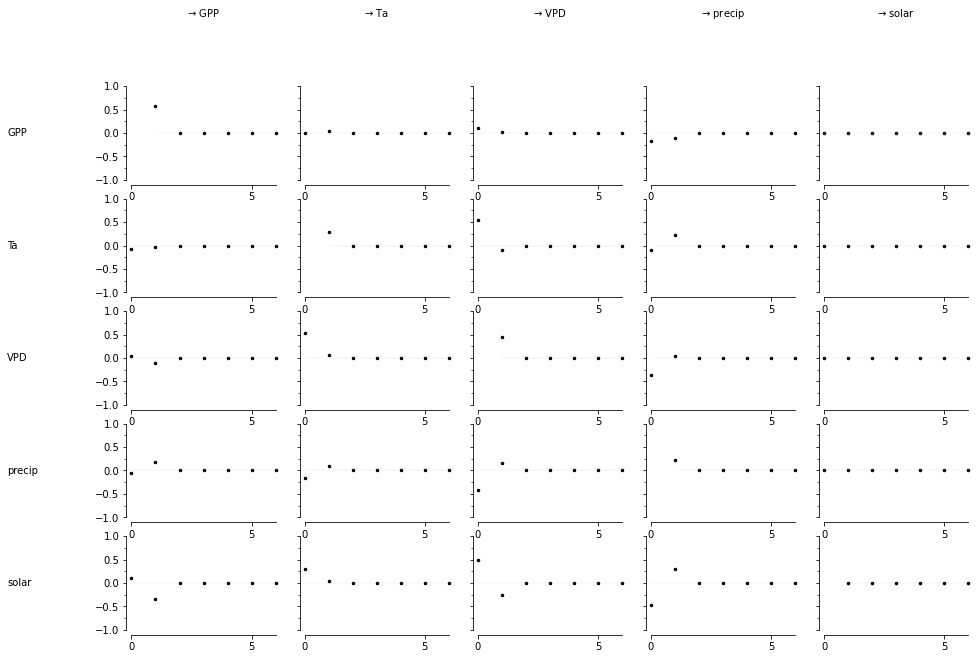

In [42]:
correlations = pcmci.run_bivci(tau_max=max_lag, val_only=True, selected_links=selected_links)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, 
                                   setup_args={'var_names':var_names, 'figsize':(15, 10),
                                    'x_base':5, 'y_base':.5})

Let's do another check and use the new ``plot_scatterplots`` function to see whether the dependencies are really linear and ``ParCorr`` is the right conditional independence test. With the argument ``scatter_lags`` set to a ``(N, N)`` integer numpy array you can choose which lag to use for every pair of variables. Here we choose the lag at which the correlations above have their maximal absolute value. Of course, you might want to use a nonlinear conditional independence test to assess the lags with maximum dependency. I.e., run ``pcmci.get_lagged_dependencies`` with ``PCMCI`` initialized with a nonlinear measure (e.g., CMIknn or GPDC as introduced below).

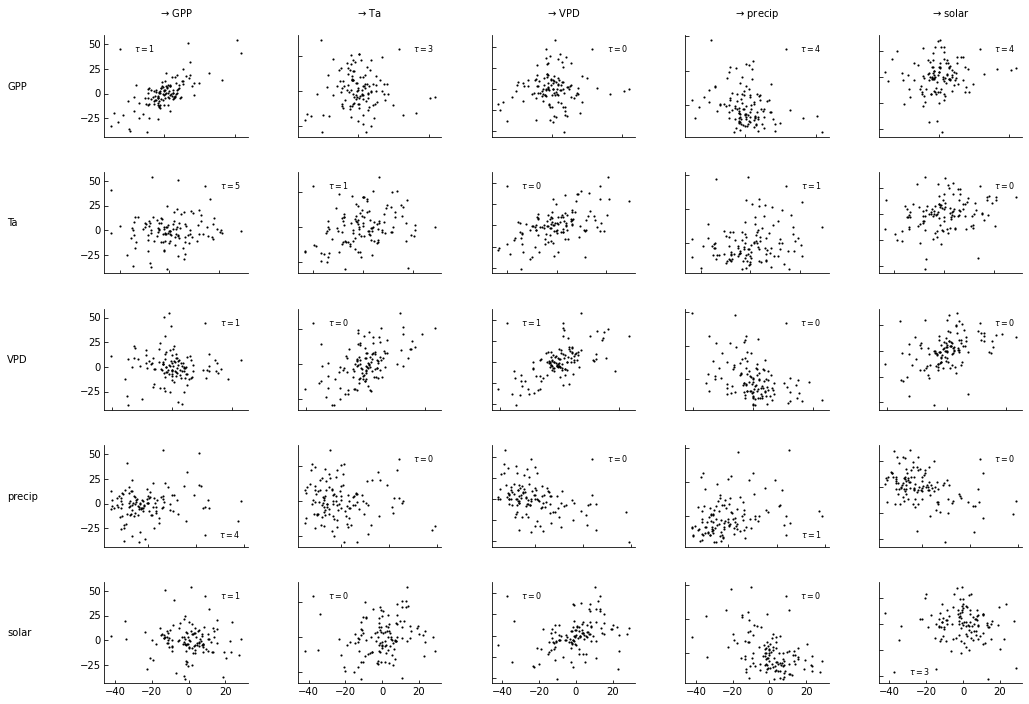

In [7]:
scatter_lags = np.argmax(np.abs(correlations), axis=2)
tp.plot_scatterplots(dataframe=dataframe, setup_args={'figsize':(15, 10)}, add_scatterplot_args={'scatter_lags':scatter_lags});


Here we set it to ``pc_alpha=0.01``. In applications a number of different values should be tested and results transparently discussed.

It is instructive to set ``verbosity=2`` and understand the output of PCMCIplus, after reading the paper and the pseudo-code. In the output contemporaneous adjacencies which are not oriented are marked by ``o--o`` and already oriented adjacencies by ``-->``.

In [29]:
tau_max = 1
pc_alpha = 0.01
pcmci.verbosity = 1

In [31]:
results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha, selected_links=selected_links)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
selected_links = {0: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 1: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 2: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 3: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 4: []}
independence test = par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable GPP has 1 link(s):
        (GPP -1): max_pval = 0.00000, min_val =  0.745

    Variable Ta has 0 link(s):

    Variable VPD has 1 link(s):
        (VPD -1): max_pval = 0.00000, min_val =  0.629

    Variable precip has 1 link(s):
        (precip -1): max_pval = 0.00093, min_val =  0.298

    Variable solar has 0 link(s):

##
## Step 2: PC algorithm with contemp. conditions a

In the **process graph**, the different entries in ``graph`` are visualized as follows:

 * ``graph[i,j,tau]='-->'`` for any ``tau > 0`` denotes a directed, lagged causal link $X^i_{t-\tau} \to X^j_t$ and is depicted by a *curved arrow* pointing from  $X^i$ to $X^j$. If also the lagged link in the other direction $X^j_{t-\tau} \to X^i_t$ present, then both curved links are drawn with opposite curvature such that they don't overlap. 

 * ``graph[i,j,0]='-->'`` and ``graph[j,i,0]='<--'`` denotes a directed, contemporaneous causal link $X^i_{t} \to X^j_t$ and is depicted by a *straight arrow* pointing from $X^i$ to $X^j$.

 * ``graph[i,j,0]='o-o'`` and ``graph[j,i,0]='o-o'`` denotes an unoriented, contemporaneous adjacency between $X^i_{t}$ and $X^j_t$ indicating that the collider and orientation rules could not be applied (Markov equivalence) and is depicted by a *straight line with circle ends* between $X^i$ and $X^j$
 
 * ``graph[i,j,0]='x-x'`` and ``graph[j,i,0]='x-x'`` denotes a conflicting, contemporaneous adjacency between $X^i_{t}$ and $X^j_t$ indicating that the directionality is undecided due to conflicting orientation rules and is depicted by a *straight line with cross ends* between $X^i$ and $X^j$
 
In each case, the link color refers to the cross-MCI value. If links occur at multiple lags between two variables, the link color and type denotes the strongest one and the label lists all significant lags in order of their strength. The node color denotes the auto-MCI value at the lag with maximum absolute value. Note that if ``val_matrix`` is not already symmetric for contemporaneous values, the maximum absolute value is shown.

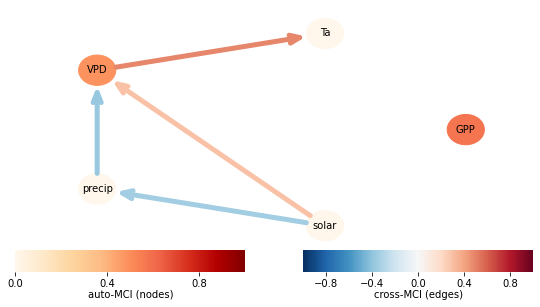

In [32]:
tp.plot_graph(
    figsize=(8,5),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI (edges)',
    node_colorbar_label='auto-MCI (nodes)',
    ); plt.show()

While the process graph is nicer to look at, the time series graph better represents the spatio-temporal dependency structure from which causal pathways can be read off.

In the **time series graph**, each entry in ``graph`` can be directly visualized. Directed lagged or contemporaneous links are drawn as arrows and unoriented or conflicting contemporaneous links as corresponding straight lines. In each case, the link color refers to the MCI value in ``val_matrix``. Also here, if ``val_matrix`` is not already symmetric for contemporaneous values, the maximum absolute value is shown.

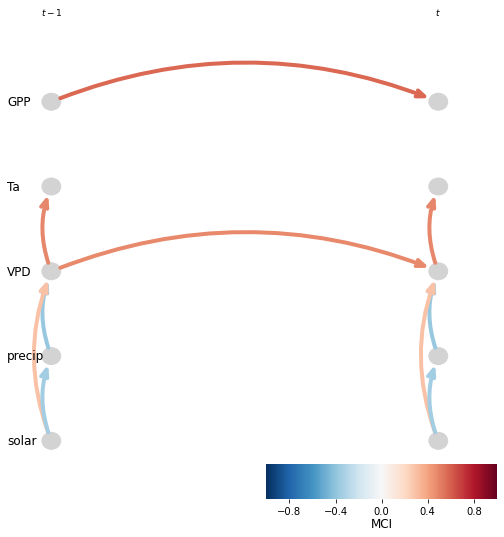

In [33]:
# Plot time series graph
tp.plot_time_series_graph(
    figsize=(8, 8),
    node_size=0.05,
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

Here PCMCIplus correctly estimates the underlying causal graph regarding both the lagged and contemporaneous links and the autodependencies.

The pair $(X^5,X^6)$ depicts a feedback cycle. These often occur in real data and the example shows that time series graphs allow to resolve feedbacks in time while other graph modeling approaches could not represent a cyclic dependency.

The contemporaneously coupled pair $(X^7,X^8)$ illustrates a case where autocorrelation helps to identify the orientation of the link. Without autocorrelation the output of PCMCIplus would be an unoriented link to indicate the Markov equivalence class.

## 4. Comparison with PCMCI

In the following we compare PCMCIplus to the standard PCMCI method that only addressed time-lagged causal discovery



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
selected_links = {0: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 1: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 2: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 3: [(0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1), (3, 0), (3, -1), (4, 0), (4, -1)], 4: []}
independence test = par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable GPP has 1 link(s):
        (GPP -1): max_pval = 0.00000, min_val =  0.745

    Variable Ta has 0 link(s):

    Variable VPD has 1 link(s):
        (VPD -1): max_pval = 0.00000, min_val =  0.629

    Variable precip has 1 link(s):
        (precip -1): max_pval = 0.00093, min_val =  0.298

    Variable solar has 0 link(s):

##
## Step 2: MCI algorithm
##

Parameters:

independ

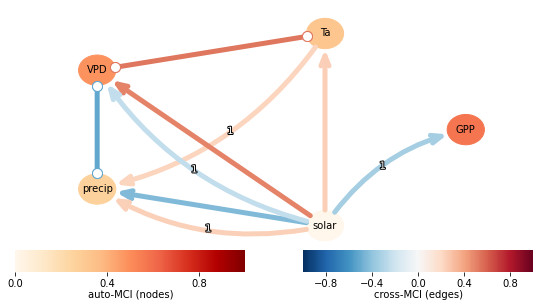

In [34]:
pcmci.verbosity = 1

results = pcmci.run_pcmci(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha, selected_links=selected_links)

tp.plot_graph(
   figsize=(8,5),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI (edges)',
    node_colorbar_label='auto-MCI (nodes)',
    );

## Compare with LPCMCI

PCMCI+ assumes there are no hidden variables, while LPCMCI does not

In [44]:
# # Create a LPCMCI object, passing the dataframe and (conditional)
# # independence test objects.
# # parcorr = ParCorr(significance='analytic')
# from tigramite.lpcmci import LPCMCI
# lpcmci = LPCMCI(dataframe=dataframe, 
#                 cond_ind_test=parcorr,
#                 verbosity=0)

# # Run LPCMCI
# results = lpcmci.run_lpcmci(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha, selected_links=selected_links)

# tp.plot_graph(
#    figsize=(8,5),
#     val_matrix=results['val_matrix'],
#     graph=results['graph'],
#     var_names=var_names,
#     link_colorbar_label='cross-MCI (edges)',
#     node_colorbar_label='auto-MCI (nodes)',
#     );

## Compare with correlation model

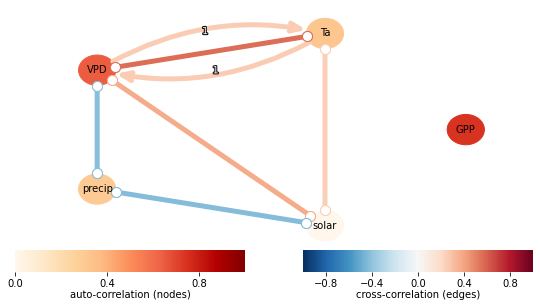

In [41]:
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=0)

results = pcmci.get_lagged_dependencies(tau_max=tau_max, selected_links=selected_links)

tp.plot_graph(val_matrix=results['val_matrix'],
              figsize=(8,5),
                graph=results['p_matrix']<=pc_alpha,
                var_names=var_names,
                link_colorbar_label='cross-correlation (edges)',
                node_colorbar_label='auto-correlation (nodes)',);